# Soda, pop, coke: words for soft drinks, and their regional associations in the United States

We will collect a large number of messages from Twitter, along with user location information, and try to find out whether the various words for soft drinks are associated with certain regions in the US.

Specifically, the words of interest are:
- soda
- pop
- coke

The regions are:
- the East and West Coasts
- the Midwest
- the South

In [1]:
import tweepy
from pprint import pprint
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopy
import geopy.distance
from geopy.geocoders import GoogleV3
import shelve
import time
from tqdm.notebook import tqdm, trange
from pprint import pprint
import os.path
import random
import geopandas as gpd
import math
import pingouin as pg

In [2]:
plt.rcParams["figure.figsize"] = (16, 9)

In [3]:
def tweet_ok(tweet):
    # basic sanity checks
    # TBD: add more criteria
    if location_ok(tweet.user.location) and True:
        return True
    return False


def location_ok(loc):
    # sanity checks for the user location string
    # TBD: add more criteria
    if loc != '' and True:
        return True
    return False


def min_id(cache):
    # minimum ID in a dictionary of tweets
    # key: ID
    # value: the whole tweet object
    if cache != {}:
        # shelve wants strings as keys :(
        tids = list(map(int, list(cache.keys())))
        return min(tids)
    else:
        return -1


def is_in_us(loc):
    # see if location is valid and is in the United States
    if loc is not None:
        if loc.address.endswith('USA'):
            return True
    return False

In [4]:
# drink types and their current best search strings
# this could be improved
drinks = {
    'soda': '"drink soda" -pop -coke',
    'pop' : '"drink pop" -soda -coke',
    'coke': '"drink coke" -soda -pop'
}

# cache the tweets, to work around the limitations of Twitter API
# key: tweet ID
# value: [the whole tweet object, geolocation object]
dcache = {}
# pick the oldest tweets from caches, and resume search from there backwards
oldest_id = {}
for d in drinks:
    dcache[d] = shelve.open(d)
    # mark oldest cached tweet
    oldest_id[d] = min_id(dict(dcache[d]))

# cache the geocoding lookops, to keep cost down
# key: user location string
# value: result from Google location search with key as argument

gc = shelve.open("geocache")

In [5]:
# while this parameter is True, the notebook will just keep growing the caches
# change it to False to stop searching and use existing caches to analyze data
KEEP_SEARCHING = False

if KEEP_SEARCHING:
    %run ../credentials.py
    
    # ../credentials.py
    # ACCESS_TOKEN = 'XXXXXXXXXXXX'
    # ACCESS_SECRET = 'XXXXXXXXXXXX'
    # CONSUMER_KEY = 'XXXXXXXXXXXX'
    # CONSUMER_SECRET = 'XXXXXXXXXXXX'
    # GOOGLE_KEY = 'XXXXXXXXXXXX'


    auth = tweepy.OAuthHandler(consumer_key=CONSUMER_KEY, consumer_secret=CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
    api = tweepy.API(auth)

    # connect to Google for user location searches
    geolocator = GoogleV3(api_key = GOOGLE_KEY)
    
# the main data collection loop
while KEEP_SEARCHING:
    for d, ss in drinks.items():
        # print current search
        print(d, oldest_id[d])
        # get tweets
        tweet_list = api.search(q = ss, count = 100, max_id = oldest_id[d])

        for t in tqdm(tweet_list):
            if tweet_ok(t):
                # user location string from Twitter
                uloc = t.user.location
                # Google's interpretation of the user location (including lat/long)
                location = None
                if uloc not in gc:
                    # Avoid hitting the rate limit
                    time.sleep(0.02)
                    location = geolocator.geocode(uloc)
                    if location is not None:
                        # good location, cache it
                        gc[uloc] = location
                else:
                    # location is in cache
                    location = gc[uloc]
                if is_in_us(location):
                    # cache the tweet
                    dcache[d][str(t.id)] = [t, location]
                    
        # push oldest ID marker further down even if we don't cache that tweet
        # this is to prevent the code from getting stuck in a gap of 100 non-cacheable tweets
        oldest_id[d] = min([t.id for t in tweet_list])
    
    # a gentle way to break the loop and move to data analysis
    # just manually create an empty file
    if os.path.exists('circuit_breaker.txt'):
        print('Found circuit breaker, data collection will stop.')
        break

In [6]:
# number of plottable points
# and a few sample tweets
for k, v in dict(dcache).items():
    print(k, len(v))
    pprint([(t[0].text, t[1].address) for t in list(dict(v).values())[0:5]])
    print()

soda 419
[("@Edenza I don't do (meat) burgers &amp; almost never drink soda, so it was "
  'too easy for me 😉',
  'Charleston, WV, USA'),
 ('I will never understand how people drink soda every day',
  'Connecticut, USA'),
 ('@alexibanez50 That was my dinner yesterday, well not the joya, I don’t '
  'really drink soda Hehe',
  'Texas, USA'),
 ("@cypoints @Daikichi_Dad At least try the baja blast. I don't even drink "
  'soda anymore but I still have it once in awhile.',
  '100 Shoreline Hwy Building B - Suite 100, Mill Valley, CA 94941, USA'),
 ('1- i don’t drink soda. 2- if i did drink it, it fasho wouldnt be DR PEPPER',
  'Los Angeles, CA, USA')]

pop 169
[("@CanadaDry ok, you guys are promoting the hell out of this to me. i don't "
  "even drink pop, but i'll try it next time… https://t.co/ksXQyidKpf",
  'South Side, Chicago, IL, USA'),
 ('@Kim04274726 🤣! You are a wild woman Kim! Quite the fermentation process 😆! '
  "To be honest I don't drink coffee. I ha… https://t.co/l3CI0t3G9u"

In [7]:
# number of cached user location strings
# and a few examples
print(len(dict(gc)))
for v in list(dict(gc).values())[0:10]:
    print(v)

4867
Catamarca, Catamarca Province, Argentina
Colombia
New Jersey, USA
Aragon, Spain
Moses Lake, WA 98837, USA
Michigan, USA
Vera, Santa Fe Province, Argentina
Thailand
209 E Main St, Cherryvale, KS 67335, USA
224 W 30th St SUITE 809, New York, NY 10001, USA


In [8]:
# states_21basic
# https://moodle.cornellcollege.edu/mod/resource/view.php?id=46759&forceview=1
# the shape of the US map with state lines
usa = gpd.read_file('./states_21basic/states.shp')

# only keep continental US
ucont = usa[usa.STATE_ABBR != 'AK']
ucont = ucont[usa.STATE_ABBR != 'HI']

C:\Users\flori\Anaconda3\lib\site-packages\geopandas\geodataframe.py:546: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


In [9]:
# extract user lat/long pairs from Twitter data
geos = {}
for k, v in dict(dcache).items():
    geos[k] = [(t[1].latitude, t[1].longitude) for t in list(dict(v).values())]

# create the plottable GeoDataFrame objects from lat/long
points = {}
# keep unfuzzed (precise) data for calculations later
pdata = {}

for drink in geos:
    # precise data
    pdata[drink] = pd.DataFrame({
        # > -130 means cut off Alaska and Hawaii
        # also fuzz the coordinates a bit so they're easier to see on the map
        'lat': [g[0] for g in geos[drink] if g[1] > -130],
        'long': [g[1] for g in geos[drink] if g[1] > -130]
    })
    
    # plottable (fuzzed) data
    df = pd.DataFrame({
        # > -130 means cut off Alaska and Hawaii
        # also fuzz the coordinates a bit so they're easier to see on the map
        'lat': [g[0] + random.triangular(-2, 2) for g in geos[drink] if g[1] > -130],
        'long': [g[1] + random.triangular(-2, 2) for g in geos[drink] if g[1] > -130]
    })
    gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.long, df.lat))
    points[drink] = gdf

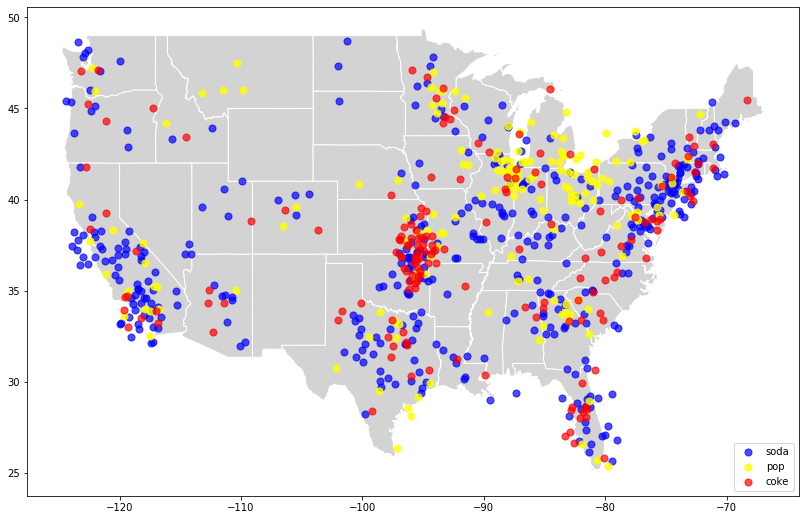

In [10]:
# plot the map and all user locations
# https://medium.com/@erikgreenj/mapping-us-states-with-geopandas-made-simple-d7b6e66fa20d
ms = 50
fig, ax = plt.subplots(1, 1)
ucont.plot(ax=ax, color='lightgrey', edgecolor='white')
points['soda'].plot(ax=ax, color='blue', label='soda', markersize=ms, alpha=0.7)
points['pop'].plot(ax=ax, color='yellow', label='pop', markersize=ms, alpha=0.8)
points['coke'].plot(ax=ax, color='red', label='coke', markersize=ms, alpha=0.7)
# figsize() doesn't work properly, also need set_aspect()
# must be a geopandas bug
# set_aspect() would not be needed with plain matplotlib
ax.legend(loc='lower right')
ax.set_aspect(aspect=1.5)

This is where we define the three regions. The selection of states that go into each region is somewhat subjective.

For each region we define a centroid. We will pick a major city near the geographic center of each region.

For the two coastal areas, we will pick one centroid for each; the smallest distance to either one centroid will be kept.

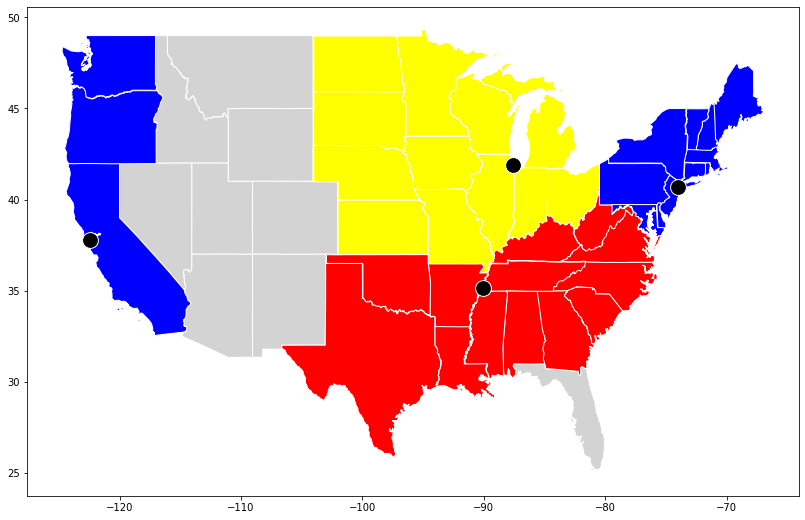

In [11]:
def state_plotter(geodf, states, color):
    for s in states:
        geodf[geodf.STATE_ABBR == f'{s}'].plot(ax=ax, color=color, edgecolor='white')


def city_plotter(city, ax):
    city_df = pd.DataFrame({
        'lat': [city[0]],
        'long': [city[1]]
    })
    city_geodf = gpd.GeoDataFrame(
        city_df,
        geometry = gpd.points_from_xy(city_df.long, city_df.lat)
    )
    city_geodf.plot(ax = ax, color = 'black', edgecolor = 'white', markersize = 250)


fig, ax = plt.subplots(1, 1)
ucont.plot(ax=ax, color='lightgrey', edgecolor='white')

state_plotter(ucont, ['CA', 'OR', 'WA', 'ME', 'NH', 'VT', 'MA', 'RI', 'CT', 'NY', 'PA', 'NJ', 'DE', 'MD'], 'blue')
state_plotter(ucont, ['IL', 'IN', 'IA', 'KS', 'MI', 'MN', 'MO', 'NE', 'ND', 'OH', 'SD', 'WI'], 'yellow')
state_plotter(ucont, ['AL', 'AR', 'GA', 'KY', 'LA', 'MS', 'NC', 'OK', 'SC', 'TN', 'TX', 'VA', 'WV'], 'red')

chicago = (41.878, -87.63)
san_francisco = (37.775, -122.42)
new_york = (40.713, -74.006)
memphis = (35.15, -90.05)

city_plotter(chicago, ax)
city_plotter(san_francisco, ax)
city_plotter(new_york, ax)
city_plotter(memphis, ax)

ax.set_aspect(aspect=1.5)

In [12]:
def calc_dist(point, centroids):
    # calculate distance from point to regional centroid
    # where there are multiple centroids, return the minimum distance
    d = min([geopy.distance.geodesic(point, ctr).kilometers for ctr in centroids])
    return d


# distances from user locations to regional centroids
dist = {}
# same, but keep (lat, long) to identify individual points (for pairwise comparison later)
dist_full = {}
for drink, points in geos.items():
    dist[drink] = pd.DataFrame({'points': points})
    dist[drink]['Midwest'] = dist[drink].apply(lambda row: calc_dist(row['points'], [chicago]), axis='columns')
    dist[drink]['South'] = dist[drink].apply(lambda row: calc_dist(row['points'], [memphis]), axis='columns')
    dist[drink]['East/West Coasts'] = dist[drink].apply(lambda row: calc_dist(row['points'], [san_francisco, new_york]), axis='columns')
    dist_full[drink] = dist[drink].copy()
    dist[drink].drop(columns=['points'], inplace=True)

In [13]:
def dist_hist(df, title, ax):
    colors = ['blue', 'yellow', 'red']
    columns = ['East/West Coasts', 'Midwest', 'South']
    ax.hist(df[columns].to_numpy(), color=colors, label=columns)
    ax.set_title(title)
    ax.legend()

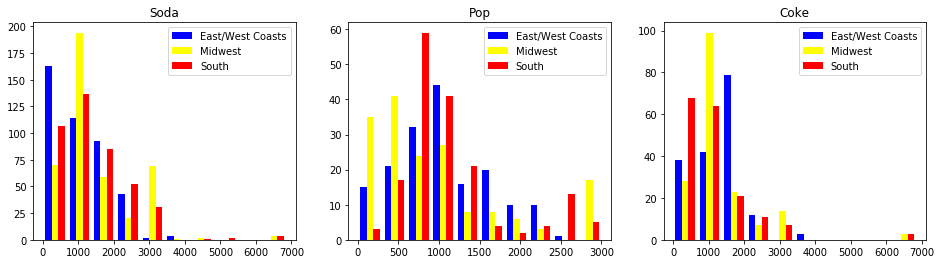

In [14]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16,4))
dist_hist(dist['soda'], 'Soda', ax0)
dist_hist(dist['pop'], 'Pop', ax1)
dist_hist(dist['coke'], 'Coke', ax2)

**Data is skewed**. log10() is too strong as a correction. Let's use sqrt() instead to fix the skew.

In [15]:
dist_sq = {}
for drink, dists in dist.items():
    dist_sq[drink] = np.sqrt(dist[drink])

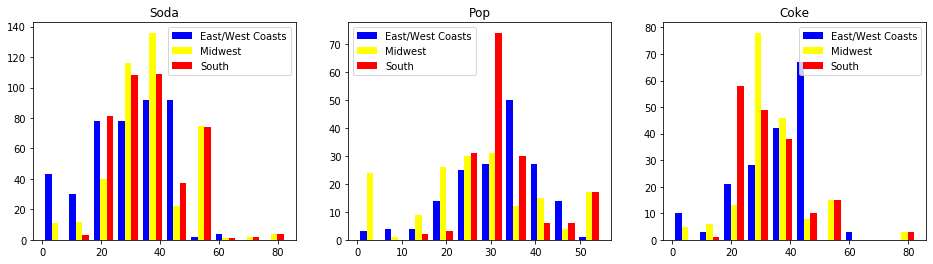

In [16]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16,4))
dist_hist(dist_sq['soda'], 'Soda', ax0)
dist_hist(dist_sq['pop'], 'Pop', ax1)
dist_hist(dist_sq['coke'], 'Coke', ax2)

In [17]:
def dist_box(df, title, ax):
    columns = ['East/West Coasts', 'Midwest', 'South']
    ax.boxplot(df[columns].to_numpy(), labels=columns)
    ax.set_title(title)

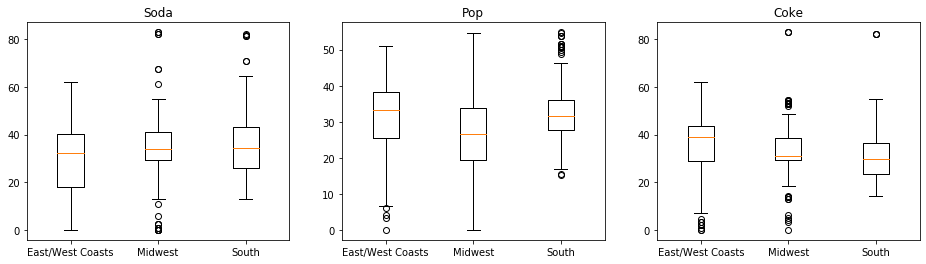

In [18]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16,4))
dist_box(dist_sq['soda'], 'Soda', ax0)
dist_box(dist_sq['pop'], 'Pop', ax1)
dist_box(dist_sq['coke'], 'Coke', ax2)

- distances are now normal-ish
- there's plenty of large outliers
- shapes are somewhat similar, but not identical

Let's test normality with Shapiro-Wilk:

In [19]:
for drink, dists in dist_sq.items():
    print(drink)
    print(pg.normality(dists, method='shapiro'))
    print()

soda
                         W          pval  normal
Midwest           0.949953  1.048826e-10   False
South             0.944103  1.825434e-11   False
East/West Coasts  0.963360  1.009224e-08   False

pop
                         W          pval  normal
Midwest           0.949750  1.011910e-05   False
South             0.891191  8.475067e-10   False
East/West Coasts  0.963842  2.227792e-04   False

coke
                         W          pval  normal
Midwest           0.885113  2.560096e-10   False
South             0.841621  1.841825e-12   False
East/West Coasts  0.896652  1.160760e-09   False



As expected, **distributions are not normal**.

How about variances? Are they the same (homoscedastic) or not? Let's calculate individual standard deviations, and also test with Levene.

In [20]:
for drink, dists in dist_sq.items():
    print(drink)
    print(dist_sq[drink].std())
    print()

soda
Midwest             12.852264
South               11.760063
East/West Coasts    13.891187
dtype: float64

pop
Midwest             14.984008
South                8.520237
East/West Coasts     9.908713
dtype: float64

coke
Midwest             12.055555
South               11.395431
East/West Coasts    12.288377
dtype: float64



In [21]:
for drink, dists in dist_sq.items():
    print(drink)
    print(pg.homoscedasticity(dist_sq['coke'], method='levene'))
    print()

soda
               W  pval  equal_var
levene  0.324243   1.0       True

pop
               W  pval  equal_var
levene  0.324243   1.0       True

coke
               W  pval  equal_var
levene  0.324243   1.0       True



For soda and coke, standard deviations are very close. For pop, the largest standard deviation is less than 2x the smallest standard deviation, which is close enough.

**Variances are about the same**. ANOVA may be appropriate; we will apply the Welch corrections to ANOVA just in case.

Let's test the means with ANOVA and the medians with Kruskal-Wallis:
- null hypothesis: the central values (means for ANOVA, medians for K-W) are the same
- alternative hypothesis: the central values are different

In [22]:
for drink,  dists in dist_sq.items():
    print(drink)
    print('\tWelch ANOVA')
    print(pg.welch_anova(data=dist_sq[drink].melt(), dv='value', between='variable'))
    print()
    print('\tKruskal-Wallis')
    print(pg.kruskal(data=dist_sq[drink].melt(), dv='value', between='variable'))
    print('#################################################################')

soda
	Welch ANOVA
     Source  ddof1       ddof2          F         p-unc       np2
0  variable      2  832.132155  33.535748  9.836043e-15  0.054657

	Kruskal-Wallis
           Source  ddof1          H         p-unc
Kruskal  variable      2  42.536021  5.799899e-10
#################################################################
pop
	Welch ANOVA
     Source  ddof1       ddof2          F     p-unc       np2
0  variable      2  322.746234  11.236159  0.000019  0.053818

	Kruskal-Wallis
           Source  ddof1          H     p-unc
Kruskal  variable      2  25.533941  0.000003
#################################################################
coke
	Welch ANOVA
     Source  ddof1       ddof2         F     p-unc       np2
0  variable      2  345.634317  1.636253  0.196213  0.006201

	Kruskal-Wallis
           Source  ddof1         H     p-unc
Kruskal  variable      2  18.70151  0.000087
#################################################################


The null hypothesis is rejected by Kruskal-Wallis for all types of drinks, with very small p-values. ANOVA fails to reject H0 for 'coke': **mean values may not be statistically different for 'coke'**. Due to the many outliers, perhaps the means are not the best measure for coke.

**The median distances to regional centroids are different for all drinks** in a statistically meaningful way. The different names for drinks indeed tend to cluster close to certain regions. Let's proceed with the calculations.

Confidence intervals for mean distances:

In [23]:
for drink, dists in dist_sq.items():
    print(drink)
    for reg in ['East/West Coasts', 'Midwest', 'South']:
        print(reg)
        print(pg.compute_bootci(dist_sq[drink][reg], func='mean', n_boot=10000)**2)
    print()

soda
East/West Coasts
[786.2416 938.8096]
Midwest
[1202.7024 1380.8656]
South
[1213.1289 1373.4436]

pop
East/West Coasts
[ 900.     1092.3025]
Midwest
[584.1889 823.69  ]
South
[ 990.9904 1157.3604]

coke
East/West Coasts
[1074.5284 1327.8736]
Midwest
[1011.8761 1254.5764]
South
[ 948.0241 1169.64  ]



For pairwise t-tests, we need the same data, but retain the identity of each point also - the (lat, long) pair.

This is how the original data looks like - wide form, including (lat, long):

In [24]:
dist_full['soda']

,points,Midwest,South,East/West Coasts
0,"(38.3498195, -81.6326234)",643.840751,830.887645,705.928349
1,"(41.6032207, -73.087749)",1208.654768,1642.280653,125.355579
2,"(31.9685988, -99.9018131)",1547.661949,979.947747,2151.010070
3,"(37.8809347, -122.5147672)",2996.006034,2909.024576,14.417270
4,"(34.0522342, -118.2436849)",2809.520420,2580.409846,559.084903
...,...,...,...,...
414,"(42.3600825, -71.0588801)",1369.244229,1829.027544,306.477134
415,"(38.6270025, -90.19940419999999)",421.966664,386.092200,1406.521886
416,"(33.4734978, -82.0105148)",1055.750817,762.763693,1072.282328
417,"(40.7282239, -73.7948516)",1164.402088,1554.148509,17.919734


sqrt() all distances to reduce skew:

In [25]:
for drink in dist_full.keys():
    for reg in ['East/West Coasts', 'Midwest', 'South']:
        dist_full[drink][reg] = np.sqrt(dist_full[drink][reg])

This is how the data will look like if we melt it to long form. We need the long form for pg.pairwise_ttests().

In [26]:
dist_full['soda'].melt(id_vars=['points'])

,points,variable,value
0,"(38.3498195, -81.6326234)",Midwest,25.374017
1,"(41.6032207, -73.087749)",Midwest,34.765713
2,"(31.9685988, -99.9018131)",Midwest,39.340335
3,"(37.8809347, -122.5147672)",Midwest,54.735784
4,"(34.0522342, -118.2436849)",Midwest,53.004909
...,...,...,...
1252,"(42.3600825, -71.0588801)",East/West Coasts,17.506488
1253,"(38.6270025, -90.19940419999999)",East/West Coasts,37.503625
1254,"(33.4734978, -82.0105148)",East/West Coasts,32.745722
1255,"(40.7282239, -73.7948516)",East/West Coasts,4.233171


Pairwise t-tests for mean distances, for each type of drink, comparing mean distances to regional centroids:

In [27]:
for drink, dists in dist_full.items():
    print(drink)
    print(pg.pairwise_ttests(dv='value', between='variable', subject='points', data=dists.melt(id_vars=['points'])))
    print('###################################################################################')

soda
   Contrast        A                 B  Paired  Parametric         T    dof  \
0  variable  Midwest             South   False        True -0.041962  836.0   
1  variable  Midwest  East/West Coasts   False        True  7.069345  836.0   
2  variable    South  East/West Coasts   False        True  7.390748  836.0   

        Tail         p-unc       BF10    hedges  
0  two-sided  9.665391e-01      0.077 -0.002896  
1  two-sided  3.286118e-12  1.887e+09  0.487975  
2  two-sided  3.543285e-13  1.637e+10  0.510160  
###################################################################################
pop
   Contrast        A                 B  Paired  Parametric         T    dof  \
0  variable  Midwest             South   False        True -4.724679  336.0   
1  variable  Midwest  East/West Coasts   False        True -3.730814  336.0   
2  variable    South  East/West Coasts   False        True  1.103390  336.0   

        Tail     p-unc      BF10    hedges  
0  two-sided  0.000003  4110

For **soda**, the shortest mean distance is to **East/West Coasts**.

For **pop**, the shortest mean distance is to **Midwest**.

For coke, it's impossible to tell which mean distance is shortest.

In [28]:
dist['soda'].describe()

,Midwest,South,East/West Coasts
count,419.000000,419.000000,419.000000
mean,1453.273253,1429.020890,1054.493494
std,1001.829339,976.613008,778.099130
min,0.020972,168.999545,0.025058
25%,872.710064,678.165620,327.924341
50%,1151.971946,1189.051311,1031.951911
75%,1682.528078,1858.224751,1633.996202
max,6862.131522,6720.337260,3871.014861


In [29]:
dist['pop'].describe()

,Midwest,South,East/West Coasts
count,169.000000,169.000000,169.000000
mean,921.181410,1140.412573,1094.574861
std,826.981447,637.206790,577.897052
min,0.020972,236.593965,0.025058
25%,382.466656,776.021869,651.475529
50%,710.605173,1001.156334,1116.757540
75%,1150.272241,1291.635629,1471.442556
max,2985.122083,3002.056524,2609.892729


In [30]:
dist['coke'].describe()

,Midwest,South,East/West Coasts
count,174.000000,174.000000,174.000000
mean,1268.608259,1178.889715,1354.203761
std,1003.283316,994.786984,738.324782
min,0.020972,201.487702,0.025058
25%,872.710064,543.533231,829.819799
50%,956.007468,887.393096,1531.905088
75%,1473.528586,1337.717216,1914.735021
max,6848.782055,6705.142413,3857.439323


For **soda**, the shortest median distance is to **East/West Coasts**.

For **pop**, the shortest median distance is to **Midwest**.

For **coke**, the shortest median distance is to **South**.